In [1]:
import numpy as np, pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm


In [2]:
trainFile=pd.read_csv('../input/train_merged.csv',encoding='latin-1')
testFile=pd.read_csv('../input/test_merged.csv', encoding='latin-1')

In [3]:
totaldata= trainFile['articleBody'].tolist() + trainFile['Headline'].tolist()+testFile['articleBody'].tolist()+testFile['Headline'].tolist()

In [4]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=80, stop_words='english')

In [5]:
tfidf_vect.fit(totaldata)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=80, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='\\w{1,}', tokenizer=None, use_idf=True,
        vocabulary=None)

In [6]:
train_head_vec= tfidf_vect.transform(trainFile['Headline'])
train_body_vec= tfidf_vect.transform(trainFile['articleBody'])
test_head_vec= tfidf_vect.transform(testFile['Headline'])
test_body_vec= tfidf_vect.transform(testFile['articleBody'])

In [7]:
# run and tested
import os
import re
import nltk
import numpy as np
from sklearn import feature_extraction
from tqdm import tqdm


_wnl = nltk.WordNetLemmatizer()


def normalize_word(w):
    return _wnl.lemmatize(w).lower()


def get_tokenized_lemmas(s):
    return [normalize_word(t) for t in nltk.word_tokenize(s)]


def clean(s):
    # Cleans a string: Lowercasing, trimming, removing non-alphanumeric

    return " ".join(re.findall(r'\w+', s, flags=re.UNICODE)).lower()


def remove_stopwords(l):
    # Removes stopwords from a list of tokens
    return [w for w in l if w not in feature_extraction.text.ENGLISH_STOP_WORDS]


def gen_or_load_feats(feat_fn, headlines, bodies, feature_file):
    if not os.path.isfile(feature_file):
        feats = feat_fn(headlines, bodies)
        np.save(feature_file, feats)

    return np.load(feature_file)




def word_overlap_features(features, headline, body):
    # common word/ total word
    clean_headline = clean(headline)
    clean_body = clean(body)
    clean_headline = get_tokenized_lemmas(clean_headline)
    clean_body = get_tokenized_lemmas(clean_body)
    feature = len(set(clean_headline).intersection(clean_body)) / float(len(set(clean_headline).union(clean_body)))
    features.append(feature)
    return features




def ngrams(input, n):
    input = input.split(' ')
    output = []
    for i in range(len(input) - n + 1):
        output.append(input[i:i + n])
    return output


def chargrams(input, n):
    output = []
    for i in range(len(input) - n + 1):
        output.append(input[i:i + n])
    return output


def append_chargrams(features, text_headline, text_body, size):
    grams = [' '.join(x) for x in chargrams(" ".join(remove_stopwords(text_headline.split())), size)]
    grams_hits = 0
    grams_early_hits = 0
    grams_first_hits = 0
    for gram in grams:
        if gram in text_body:
            grams_hits += 1
        if gram in text_body[:255]:
            grams_early_hits += 1
        if gram in text_body[:100]:
            grams_first_hits += 1
    features.append(grams_hits)
    features.append(grams_early_hits)
    features.append(grams_first_hits)
    return features


def append_ngrams(features, text_headline, text_body, size):
    grams = [' '.join(x) for x in ngrams(text_headline, size)]
    grams_hits = 0
    grams_early_hits = 0
    for gram in grams:
        if gram in text_body:
            grams_hits += 1
        if gram in text_body[:255]:
            grams_early_hits += 1
    features.append(grams_hits)
    features.append(grams_early_hits)
    return features


def hand_features(headlines, bodies):
    def binary_co_occurence(headline, body):
        # Count how many times a token in the title
        # appears in the body text.
        bin_count = 0
        bin_count_early = 0
        for headline_token in clean(headline).split(" "):
            if headline_token in clean(body):
                bin_count += 1
            if headline_token in clean(body)[:255]:
                bin_count_early += 1
        return [bin_count, bin_count_early]

    def binary_co_occurence_stops(headline, body):
        # Count how many times a token in the title
        # appears in the body text. Stopwords in the title
        # are ignored.
        bin_count = 0
        bin_count_early = 0
        for headline_token in remove_stopwords(clean(headline).split(" ")):
            if headline_token in clean(body):
                bin_count += 1
                bin_count_early += 1
        return [bin_count, bin_count_early]

    def count_grams(headline, body):
        # Count how many times an n-gram of the title
        # appears in the entire body, and intro paragraph

        clean_body = clean(body)
        clean_headline = clean(headline)
        features = []
        features = append_chargrams(features, clean_headline, clean_body, 2)
        features = append_chargrams(features, clean_headline, clean_body, 8)
        features = append_chargrams(features, clean_headline, clean_body, 4)
        features = append_chargrams(features, clean_headline, clean_body, 16)
        features = append_ngrams(features, clean_headline, clean_body, 2)
        features = append_ngrams(features, clean_headline, clean_body, 3)
        features = append_ngrams(features, clean_headline, clean_body, 4)
        features = append_ngrams(features, clean_headline, clean_body, 5)
        features = append_ngrams(features, clean_headline, clean_body, 6)
        return features

    def other_feature(headline, body):
        features=[]
        features= word_overlap_features(features, headline, body)
        return features
    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        lst= binary_co_occurence(headline, body) + binary_co_occurence_stops(headline, body) + count_grams(headline, body)+ other_feature(headline, body)
        X.append(lst)


    X =np.array(X)
    return X

In [8]:
train_handF= hand_features(trainFile['Headline'].tolist(), trainFile['articleBody'].tolist())
test_handF=hand_features(testFile['Headline'].tolist(), testFile['articleBody'].tolist())

49972it [08:22, 99.52it/s]
25413it [04:00, 41.90it/s]


In [9]:
from scipy.sparse import  hstack

In [10]:
train_final= hstack([train_head_vec,train_body_vec]).toarray()


In [11]:
test_final= hstack([test_head_vec,test_body_vec]).toarray()

In [12]:
train_final =np.concatenate((train_final,train_handF), axis=1)
test_final =np.concatenate((test_final,test_handF), axis=1)

In [13]:
print(type(train_final), train_final.shape, test_final.shape)

<class 'numpy.ndarray'> (49972, 187) (25413, 187)


In [14]:
trainFile.head()

,Body ID,articleBody,Headline,Stance
0,0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",unrelated
1,0,A small meteorite crashed into a wooded area i...,Tourist dubbed Spider Man after spider burro...,unrelated
2,0,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,unrelated
3,0,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated
4,0,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,unrelated


In [15]:
train_labels= trainFile['Stance'].copy()
test_labels= testFile['Stance'].copy()

In [16]:
from sklearn.metrics import accuracy_score


from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha=0.34)
mnb.fit(train_final, train_labels)

MultinomialNB(alpha=0.34, class_prior=None, fit_prior=True)

In [17]:
#testing naive bayes
prediction = mnb.predict(test_final)
accuracy_score(test_labels,prediction)

0.8256404202573486

In [18]:
np.unique(prediction)

array(['agree', 'disagree', 'discuss', 'unrelated'], dtype='<U9')

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

In [20]:
matrix1 = confusion_matrix(test_labels, prediction)

In [21]:
matrix1

array([[  749,    80,   828,   246],
       [  210,    31,   258,   198],
       [  847,    93,  2856,   668],
       [  217,    57,   729, 17346]])

In [22]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

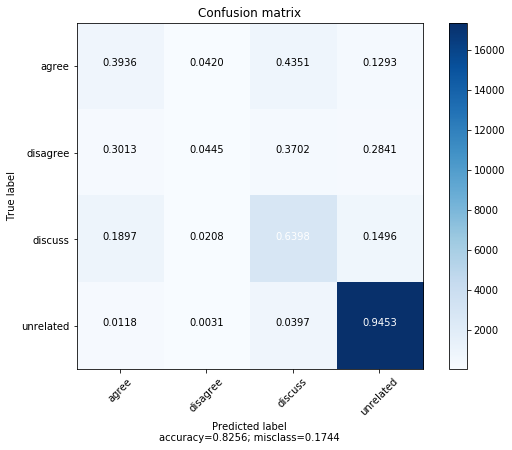

In [23]:
plot_confusion_matrix(cm=matrix1,target_names=['agree', 'disagree', 'discuss', 'unrelated'])

In [24]:
trainFile['Stance'].value_counts()

unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: Stance, dtype: int64

In [25]:
testFile['Stance'].value_counts()

unrelated    18349
discuss       4464
agree         1903
disagree       697
Name: Stance, dtype: int64